<a href="https://colab.research.google.com/github/tanumalik12/Churn-Analysis/blob/main/churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Importing Necessary libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df=pd.read_csv("Bank Customer Churn Prediction.csv")

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


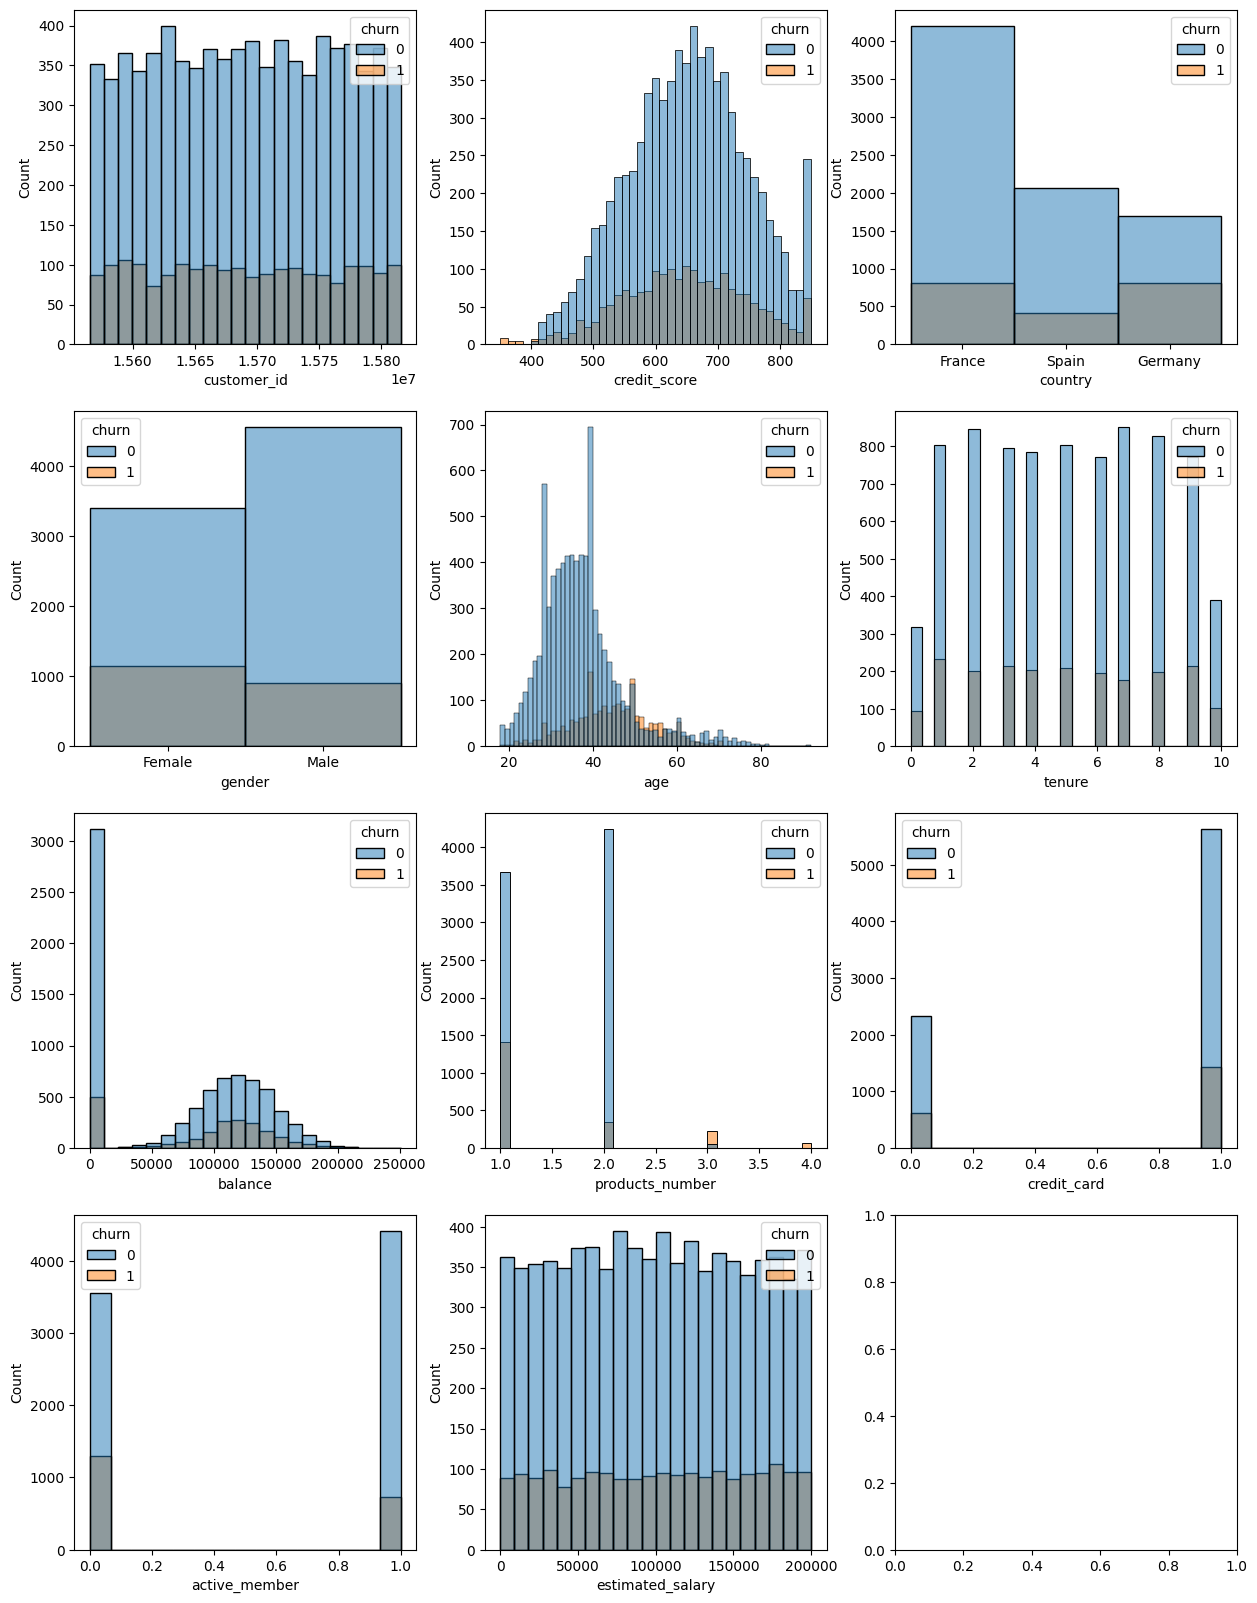

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15,20))
axs=axs.flat
for i in range(len(df.columns)-1):
    sns.histplot(data=df, x=df.columns[i],hue="churn",ax=axs[i])


The "country" column is a categorical feature. Let's create some dummies to replace the column

In [7]:
country=pd.get_dummies(df["country"],dtype=int)
df=pd.concat([df,country],axis=1)
df.drop("country",axis=1,inplace=True)
df.head()

,customer_id,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain
0,15634602,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,15647311,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,15619304,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,15701354,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,15737888,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


Transform the gender column into a binary column and rename it.

In [8]:
df.rename(columns={"gender":"male"},inplace=True)
df.replace({"Female":0,"Male":1},inplace=True)

In [9]:
#We can't use the customer_id for our ML model
df.drop("customer_id",axis=1,inplace=True)


<Axes: >

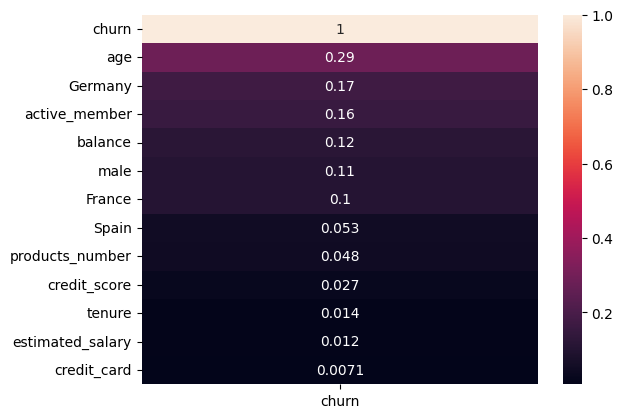

In [10]:
#Now let's analyse the correlation of each feature with our target value "churn"
corr=df.corr()["churn"]
corr=corr.abs().sort_values(ascending=False)
sns.heatmap(data=corr.to_frame(),annot=True)

In order to avoid overfitting, we should remove all columns that do not have a significant correlation with our target value (churn). Therefore, I ll remove all features with a correlation lower than 0.04

In [11]:
df_model=df.drop(columns=["credit_score","tenure","estimated_salary","credit_card"])

In [12]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


Now, let's build our model. I will use Logistic Regression as well as a Random Forest Classifier as model and compare their performance. However, in a first step I need to prepare that data and split it into a train and a test set.

In [13]:
X=df.drop("churn",axis=1).to_numpy()
y=df["churn"].to_numpy()

In [14]:
#Using the standard scaler for our features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.33, random_state=42)

Logistic Regression

In [16]:
model=LogisticRegression(random_state=42)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [17]:
confusion_matrix(y_test,y_pred)

array([[2545,  112],
       [ 510,  133]])

In [18]:
accuracy_score(y_test,y_pred)

0.8115151515151515

In [19]:
#Let's also perform a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2657
           1       0.54      0.21      0.30       643

    accuracy                           0.81      3300
   macro avg       0.69      0.58      0.60      3300
weighted avg       0.78      0.81      0.78      3300



In [20]:
#Now, let's see if we can get a better result using LogisiticRegressionCV
model_cv=LogisticRegressionCV(random_state=42)
model_cv.fit(X_train,y_train)
y_pred_cv=model_cv.predict(X_test)

In [21]:
model_cv.get_params()


{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [22]:
confusion_matrix(y_test,y_pred_cv)

array([[2552,  105],
       [ 514,  129]])

In [23]:
#Indded the accuracy score has increased slightly
accuracy_score(y_test,y_pred_cv)


0.8124242424242424

In [24]:
print(classification_report(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2657
           1       0.55      0.20      0.29       643

    accuracy                           0.81      3300
   macro avg       0.69      0.58      0.59      3300
weighted avg       0.78      0.81      0.78      3300



Random Forest Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [26]:
model2=RandomForestClassifier(random_state=42)
model2.fit(X_train,y_train)
y_predict=model2.predict(X_test)


In [27]:
confusion_matrix(y_test,y_predict)

array([[2557,  100],
       [ 336,  307]])

In [28]:
accuracy_score(y_test,y_predict)

0.8678787878787879

In [29]:
print(classification_report(y_test,y_predict))


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2657
           1       0.75      0.48      0.58       643

    accuracy                           0.87      3300
   macro avg       0.82      0.72      0.75      3300
weighted avg       0.86      0.87      0.86      3300



The Random Forest performes much better than the Logisitc Regression. Let's see whether or not we can improve the results be doing parameter tuning using random search

In [30]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [31]:
rf_classifier=RandomForestClassifier()
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42)

In [32]:
y_best_rf=random_search.predict(X_test)

In [33]:
confusion_matrix(y_test,y_best_rf)

array([[2551,  106],
       [ 332,  311]])

In [34]:
accuracy_score(y_test,y_best_rf)

0.8672727272727273

In [35]:
print(classification_report(y_test,y_best_rf))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2657
           1       0.75      0.48      0.59       643

    accuracy                           0.87      3300
   macro avg       0.82      0.72      0.75      3300
weighted avg       0.86      0.87      0.86      3300



The performance has not improved, thus model2 performs best. Let's finally take a look on the feature importance.

<Axes: >

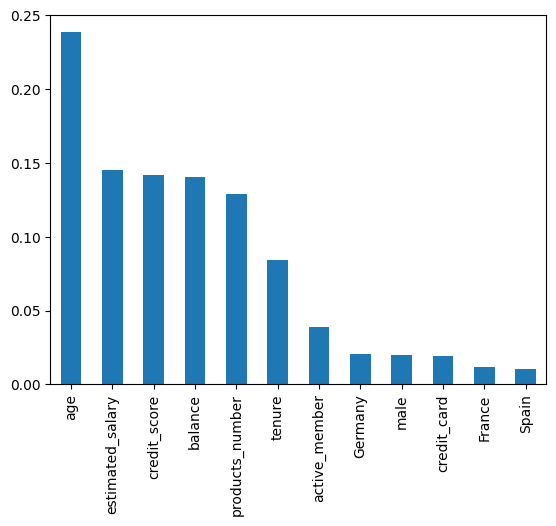

In [36]:
feature_importance=pd.Series(model2.feature_importances_,index=df.drop("churn",axis=1).columns)
feature_importance.abs().sort_values(ascending=False).plot(kind="bar")